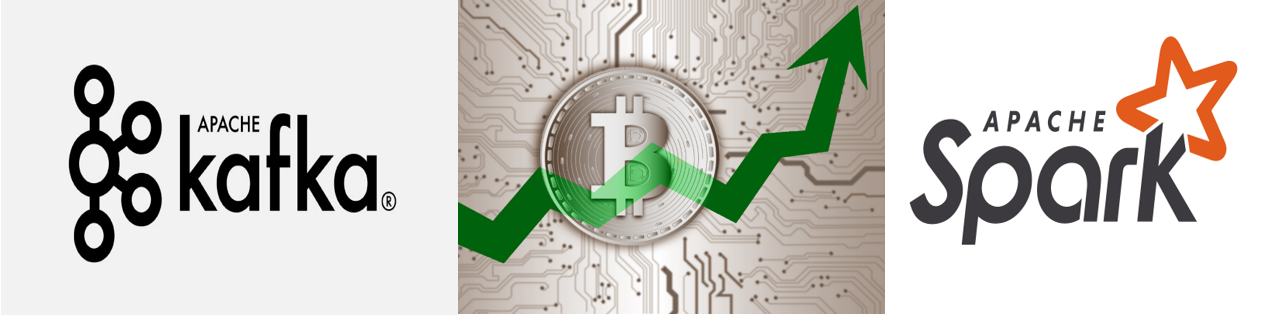

<h1 align="center">
    Trading Bot Application
</h1>


This project is about **ingesting** **Bitcoin Prices** through a **Kafka producer** and consuming it through a SparkStream Application. The Application will have the parameters of a trained **Pyspark.ml** model, which will have been trained previously. Finally the predictions will be interpreted and sent respectively in a json format to the **Alpaca API** so that **Buying and Selling Orders** can be executed in real time.

-------------------------------------------------------------------------------------------------------------------------------
<a id="index"></a>
<h1 align="left">
        INDEX
</h1>

* [Introduction](#0)
* [1. Setup](#1)
* [2. Machine Learning Model](#2)
    * [2.1. Data Gathering](#3)
        * [2.2.1. Load Data](#4)
    * [2.2. Data Cleansing](#5)
        * [2.2.1. Missing Rows](#6)
        * [2.2.2. NaN Values](#7)
    * [2.3. Feature Engineering](#8)
        * [2.3.1. Suggestions](#9)
    * [2.4. Modelling](#10)
        * [2.4.1. Vectorizing & Rescaling](#11)
        * [2.4.2.  Fit the Pipeline for prediction](#12)
    * [2.5. Evaluation](#13)
* [3. Conclusion/ Deploying?](#14)
    
<a id='0'></a>

# Introduction
-------------------------------------------------------------------------------------------------------------------------------

Throughout the next code a Spark Application will be created to train a Machine Learning Regressor, whose variables will be stored in HDFS, for later usage.

The Model will be applyed on **BTC/USD** data from 2018-2019 on a minute basis


<a id='1'></a>

# Setup
-------------------------------------------------------------------------------------------------------------------------------

Start **Hadoop**:
```python
!hadoop-start.sh
```
*Note that in order to run this notebook you will have to upload the data on your Distributed File System.*


#### Importing Libraries:
Lets first start with the libraries related to the start of the session in pyspark, where we will have to connect our machine to HDFS.

In [1]:
import findspark
findspark.init()

#Pyspark libraries
import pyspark.sql.functions as F
from pyspark.sql.functions import isnull, when, count, col, to_date, trunc, to_timestamp, udf
from pyspark.sql.types import DoubleType, StringType, IntegerType, DateType, TimestampType, StructType, StructField, FloatType

#For Rolling Windows
from pyspark.sql.window import Window

#Train Test Split
from pyspark.sql.functions import percent_rank

#For the Machine Learning Model
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor, GBTRegressor

from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler

from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

Now lets get into other important libraries that helped us to improve our sentiment analysis on the data:


In [2]:
#Python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

#### Connecting to Spark and starting our SparkApplication

In [3]:
#Start the Session
from pyspark.sql.session import SparkSession

spark = SparkSession.builder\
.config("spark.sql.warehouse.dir", "hdfs://http://localhost:9000/warehouse")\
.config("spark.sql.legacy.timeParsePolicy", "LEGACY")\
.config("spark.sql.sources.partitionOverwriteMode", "dynamic")\
.enableHiveSupport()\
.getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


[Index](#index)

<a id='2'></a>

# 2. Machine Learning Model Pyspark.ML
-------------------------------------------------------------------------------------------------------------------------------

<a id='3'></a>

## 2.1. Data Gathering


<a id='4'></a>

### 2.1.1. Load Data
The data comes from a Kaggle competition where one can found the minute prices for bitcoin for period 
From a total of 1.3 M rows, we choose the last 50k, since those are the most relevant ones.

In [4]:
btc_data = spark.read.option("header", "true").csv("hdfs://localhost:9000/datalake/raw/Kaggle/BTC.csv")

In [5]:
btc_data.limit(5).toPandas()

,_c0,Unnamed: 0,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,0,0,1514764860,1,229.0,13835.194,14013.8,13666.11,13850.176,31.55006152,13827.062092689885,None
1,1,1,1514764920,1,235.0,13835.035999999998,14052.3,13680.0,13828.102000000004,31.046432110000005,13840.362591478492,None
2,2,2,1514764980,1,528.0,13823.9,14000.4,13601.0,13801.314000000002,55.06182014000007,13806.068013568094,None
3,3,3,1514765040,1,435.0,13802.512,13999.0,13576.28,13768.04,38.78052948999999,13783.59810094648,None
4,4,4,1514765100,1,742.0,13766.0,13955.9,13554.44,13724.914,108.50163693,13735.586841893864,None


In [6]:
btc_data.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- Unnamed: 0: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- Asset_ID: string (nullable = true)
 |-- Count: string (nullable = true)
 |-- Open: string (nullable = true)
 |-- High: string (nullable = true)
 |-- Low: string (nullable = true)
 |-- Close: string (nullable = true)
 |-- Volume: string (nullable = true)
 |-- VWAP: string (nullable = true)
 |-- Target: string (nullable = true)



In [7]:
btc_data.count()

754470

[Index](#index)
<a id='5'></a>

## 2.2. Data Cleansing

In [8]:
btc_data = btc_data.drop("Unnamed: 0", "Count", "VWAP", "_c0")

In [9]:
btc_data.printSchema()

root
 |-- timestamp: string (nullable = true)
 |-- Asset_ID: string (nullable = true)
 |-- Open: string (nullable = true)
 |-- High: string (nullable = true)
 |-- Low: string (nullable = true)
 |-- Close: string (nullable = true)
 |-- Volume: string (nullable = true)
 |-- Target: string (nullable = true)



In [10]:
btc_data = btc_data.select("*").orderBy("timestamp")

We can select only the last 50K rows as these are the ones more close to the actual date. Therefore, *limit()* is applyed

<a id='6'></a>

### 2.2.1. Missing Rows

It so,metimes happens that there is no continuity in the data. For this reason, there is need to see if the time series is continuous or if there are some missing rows.

In [11]:
def missing_rows(data, timedata:str):
    
    """
    This udf helps to identify if there are missing rows in the data
    """
    
    maxi = data.agg({timedata: "max"}).collect()[0]
    mini = data.agg({timedata: "min"}).collect()[0]
    
    optimal_length = len(list(range(int(mini[0]), int(maxi[0]), 60)))
    data_length = data.count()
    
    if optimal_length != data_length:
        print("There are missing rows")
    else:
        print("No missing rows")

In [12]:
missing_rows(btc_data, "timestamp")

There are missing rows


<a id='7'></a>

### 2.2.2. NaN Values

Having done this, the **Nan** values need to be identifyed to see if there is a need to replace those with some specific observations

In [13]:
btc_data.select([count(when(isnull(c), c)).alias(c) for c in btc_data.columns]).toPandas()

,timestamp,Asset_ID,Open,High,Low,Close,Volume,Target
0,0,0,0,0,0,0,0,5


In [14]:
btc_data = btc_data.na.drop()

In [15]:
from pyspark.sql.functions import desc

In [16]:
#Make udf to convert the timestamp into a date format 
@udf("Timestamp")
def datetime(col):
    new_date_col = pd.to_datetime(col, unit="ms")
    return new_date_col

btc_data = btc_data.withColumn("timestamp", datetime(col("timestamp")))

In [17]:
btc_data = btc_data.select("*").sort(desc("timestamp"))

In [18]:
btc_data = btc_data.limit(50000)

In [19]:
btc_data.limit(5).toPandas()

,timestamp,Asset_ID,Open,High,Low,Close,Volume,Target
0,1970-01-19 01:20:34.020,1,7931.114285714285,7947.47,7908.03,7929.675714285714,12.007868039999996,-0.0007704229616199253
1,1970-01-19 01:20:33.960,1,7926.911428571429,7949.08,7906.5,7931.6,10.43345154,-0.00013309345314226593
2,1970-01-19 01:20:33.900,1,7925.097142857144,7943.3,7905.0,7926.601428571428,11.714700987202493,-0.000179848336797639
3,1970-01-19 01:20:33.840,1,7926.178571428572,7947.62,7905.1,7925.854285714285,43.69276059999998,-0.0005901182308671348
4,1970-01-19 01:20:33.780,1,7934.56155818857,7948.04,7906.0,7925.974285714285,30.205109899961247,-0.0012313568815751923


Notice that there are 15 missing values for Target, because we are going to predict the return of the next 15 mins

Lets convert the columns into double for later machine learning traininig

In [20]:
btc_data = btc_data.select(col("timestamp"), \
                           col("Asset_ID"), \
                           col('Open').cast('double'), \
                           col('High').cast("double"), \
                           col('Low').cast('double'), \
                           col('Close').cast('double'), \
                           col('Volume').cast('double'), \
                           col('Target').cast('double')
)

In [23]:
def plot_column(data, column:str, periods:int):
    
    """This function helps to automatize the plottings of the desired feature."""
    
    plot_column = data.select(column).limit(periods).toPandas().astype("float")
    
    plt.figure(figsize=(12, 6))

    plt.plot(plot_column)
    plt.title(column)
    plt.xlabel("Time")
    plt.ylabel("Price")

    plt.show()

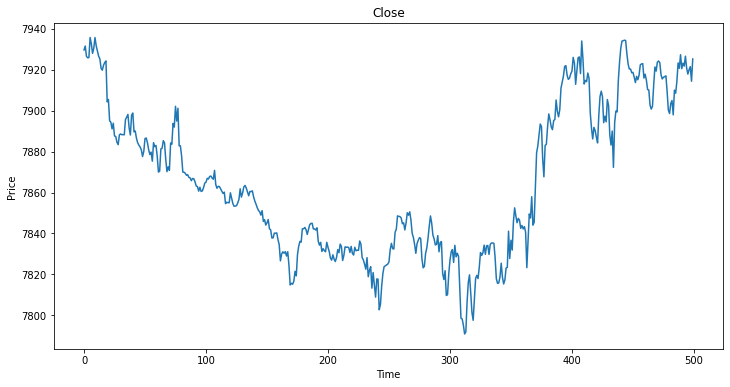

In [24]:
plot_column(btc_data, "Close", 500)

[Index](#index)
<a id='8'></a>

## 2.3. Feature Engineering
-------------------------------------------------------------------------------------------------------------------------------
This section is intended to create new futures in order to feed our model with more relevant information for regression.

In [21]:
btc_data = btc_data \
    .withColumn("Minute", F.minute("timestamp").cast("double")) \
    .withColumn("Hour", F.hour("timestamp").cast("double")) \
    .withColumn("DayofMonth", F.dayofmonth("timestamp").cast("double")) \
    .withColumn("DayofYear", F.dayofyear("timestamp").cast("double")) \
    .withColumn("DayofWeek", F.dayofweek("timestamp").cast("double")) \
    .withColumn("Year", F.year("timestamp").cast("double")) \
    .withColumn("WeekofYear", F.weekofyear("timestamp").cast("double")) \
    .withColumn("Quarter", F.quarter("timestamp").cast("double")) \
    .withColumn("Postive_Candlestick", F.greatest(col("Open"), col("Close")).cast("double")) \
    .withColumn("Negative_Candlestick", F.least(col("Open"), col("Close")).cast("double")) \
    .withColumn("Upper_shade", col("High")-col("Postive_Candlestick").cast("double")) \
    .withColumn("Lower_shade", col("Negative_Candlestick")-col("Low").cast("double")) \
    .withColumn("High2Low", col("High")/col("Low").cast("double"))


<a id='9'></a>

### 2.3.1. Suggestions

#### Rolling Windows for Closing Price:

* **Rolling Mean for periods**: +30, +60, +120, +240
* **Rolling Standart Deviation for periods**: +30, +60, +120, +240
* **Rolling Min for periods**: +30, +60, +120, +240
* **Rolling Max for periods**: +30, +60, +120, +240
```python
"""The windows require the partitionBy method since it acces the data from multiple executors (That is why there was no need to 
drop the Asset_ID column). Morover, the rows_Between method is used to define the amount of rows to be considered for the execution of, in this case, the rolling mean.
"""
btc_data = btc_data \
    .withColumn("Rolling_Mean_30", F.avg(col("Close"))
                 .over( Window.partitionBy("Asset_ID").rowsBetween(-30,0))) \
    .withColumn("Rolling_Mean_60", F.avg(col("Close"))
                 .over( Window.partitionBy("Asset_ID").rowsBetween(-60,0)))
```

In [22]:
btc_data.limit(5).toPandas()

,timestamp,Asset_ID,Open,High,Low,Close,Volume,Target,Minute,Hour,...,DayofYear,DayofWeek,Year,WeekofYear,Quarter,Postive_Candlestick,Negative_Candlestick,Upper_shade,Lower_shade,High2Low
0,1970-01-19 01:20:34.020,1,7931.114286,7947.47,7908.03,7929.675714,12.007868,-0.000770,20.0,1.0,...,19.0,2.0,1970.0,4.0,1.0,7931.114286,7929.675714,16.355714,21.645714,1.004987
1,1970-01-19 01:20:33.960,1,7926.911429,7949.08,7906.50,7931.600000,10.433452,-0.000133,20.0,1.0,...,19.0,2.0,1970.0,4.0,1.0,7931.600000,7926.911429,17.480000,20.411429,1.005385
2,1970-01-19 01:20:33.900,1,7925.097143,7943.30,7905.00,7926.601429,11.714701,-0.000180,20.0,1.0,...,19.0,2.0,1970.0,4.0,1.0,7926.601429,7925.097143,16.698571,20.097143,1.004845
3,1970-01-19 01:20:33.840,1,7926.178571,7947.62,7905.10,7925.854286,43.692761,-0.000590,20.0,1.0,...,19.0,2.0,1970.0,4.0,1.0,7926.178571,7925.854286,21.441429,20.754286,1.005379
4,1970-01-19 01:20:33.780,1,7934.561558,7948.04,7906.00,7925.974286,30.205110,-0.001231,20.0,1.0,...,19.0,2.0,1970.0,4.0,1.0,7934.561558,7925.974286,13.478442,19.974286,1.005317


[Index](#index)

<a id='10'></a>

## 2.4. Modelling
-------------------------------------------------------------------------------------------------------------------------------
The next steps involve to split the data into train and test set. For this, a new column **Rank** will be created, which basically generates a **Window**, and then there is only the need to access the percentile of this so that the is no Random split (as it is a *Time Series* data).

In [23]:
btc_data = btc_data.withColumn("rank", percent_rank().over(Window.partitionBy("Asset_ID").orderBy("timestamp")))

In [24]:
train_df = btc_data.where("rank <= .90").drop("rank")
test_df = btc_data.where("rank > .90").drop("rank")

In [25]:
test_df.limit(5).toPandas()

,timestamp,Asset_ID,Open,High,Low,Close,Volume,Target,Minute,Hour,...,DayofYear,DayofWeek,Year,WeekofYear,Quarter,Postive_Candlestick,Negative_Candlestick,Upper_shade,Lower_shade,High2Low
0,1970-01-19 01:15:34.080,1,7863.097143,7897.600000,7841.26,7857.802857,59.350863,-0.000211,15.0,1.0,...,19.0,2.0,1970.0,4.0,1.0,7863.097143,7857.802857,34.502857,16.542857,1.007185
1,1970-01-19 01:15:34.140,1,7857.380000,7893.927561,7835.62,7848.332857,74.917099,-0.002884,15.0,1.0,...,19.0,2.0,1970.0,4.0,1.0,7857.380000,7848.332857,36.547561,12.712857,1.007441
2,1970-01-19 01:15:34.200,1,7851.938571,7886.200000,7836.52,7856.737143,34.961149,-0.000485,15.0,1.0,...,19.0,2.0,1970.0,4.0,1.0,7856.737143,7851.938571,29.462857,15.418571,1.006340
3,1970-01-19 01:15:34.260,1,7856.580000,7886.200000,7840.01,7854.024286,29.880446,-0.001361,15.0,1.0,...,19.0,2.0,1970.0,4.0,1.0,7856.580000,7854.024286,29.620000,14.014286,1.005892
4,1970-01-19 01:15:34.320,1,7854.331515,7884.654837,7827.61,7841.380000,120.742069,-0.002857,15.0,1.0,...,19.0,2.0,1970.0,4.0,1.0,7854.331515,7841.380000,30.323322,13.770000,1.007288


<a id='11'></a>

### 2.4.1. Vector Assembling & Rescaling
-------------------------------------------------------------------------------------------------------------------------------
In order to train the model,  the data needs to be vectorized. For this reason the **Vector Assembler** is used. Moreover, since the data is not uniformingly scaled among the features, it has to be rescaled. For this reason, **MinMax Scaler** was used. 
This method was fitted on the vectorized feature of the training set and used for transformation for the train/test vectorized columns.

In [26]:
#First there is need to get rid of the unnecesary features that won't add value to our model:
train_df, test_df = train_df.drop("Asset_ID", "timestamp"), test_df.drop("Asset_ID", "timestamp")

In [27]:
#Select the features that are not our Target, since those have to be transformed
features = [i for i in train_df.columns if i != "Target"]

In [28]:
#Define the Vector Assembler and the MinMaxScaler to feed the Pipeline
vecAssembler = VectorAssembler(inputCols=features,outputCol="features")
minmaxscale = MinMaxScaler(inputCol="features", outputCol="scaled")

<a id='12'></a>

### 2.4.2. Fit the Pipeline for prediction

-------------------------------------------------------------------------------------------------------------------------------

Having cleaned and prepared our data, the **Pipeline** can be feeded with the **Regression** algorithms.
The chosen algorithms are:
* LinearRegression()
* RandomForestRegressor()
* GradientBoostedTreesRegressor()

In [29]:

lr = LinearRegression(labelCol="Target", featuresCol="scaled")
rf = RandomForestRegressor(labelCol="Target", featuresCol="scaled",maxDepth=10)
gbt = GBTRegressor(labelCol="Target", featuresCol="scaled",maxIter=10)

regressors = [lr, rf, gbt]

In [30]:
from pyspark.ml import Pipeline

def create_pipeline(regressor):
    return Pipeline(stages = [vecAssembler, minmaxscale, regressor])

pipelines = [create_pipeline(reg) for reg in regressors]

In [31]:
models = [pipeline.fit(train_df) for pipeline in pipelines]
models

[PipelineModel_0cd72b8467f3,
 PipelineModel_478df2eaff34,
 PipelineModel_2f627ab46130]

[Index](#index)
<a id='13'></a>

## 2.5. Evaluation
-------------------------------------------------------------------------------------------------------------------------------
Reached this point, the trained **Pipeline**, can be **Evaluated** on performance. The used metric is the **Mean Square Error**.

In [32]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol="Target",  metricName="rmse")

names = []
values = [] 
for model in models:
    prediction_df = model.transform(test_df)
    accuracy = evaluator.evaluate(prediction_df)
    names.append(type(model.stages[-1]).__name__) # the algorithm is the last stage in the pipeline
    values.append(accuracy)

data = {'name':names,'RMSE':values,'model':models}
df = pd.DataFrame(data)
df.sort_values(by=['RMSE'], inplace=True, ascending=False)  
df

,name,RMSE,model
2,GBTRegressionModel,0.001862,PipelineModel_2f627ab46130
1,RandomForestRegressionModel,0.001846,PipelineModel_478df2eaff34
0,LinearRegressionModel,0.001754,PipelineModel_0cd72b8467f3


It looks like the Linear Regression Model did the best performance on the test set. For this reason the parameters on this will be saved into HDFS, so that the predictions can be made with the most reliable model

In [36]:
print("Best model is: {}, with a Mean Squared Error of {}".format(df.iloc[2]['name'], round(df.iloc[2]['RMSE'], 3)))

Best model is: LinearRegressionModel, with a Mean Squared Error of 0.002


In [37]:
best_model=df.iloc[2]['model']

modelPath = "hdfs://localhost:9000/model-registry/BTC"
best_model.write().overwrite().save(modelPath)

[Index](#index)
<a id='14'></a>

# 3. Conclusion/ Deplopying?
-------------------------------------------------------------------------------------------------------------------------------
Reached this point, there is everything ready to start the **Real-Time flow** of BTC/USD data in our SparkApplication.

http://localhost:28888/notebooks/Kaggle/Real_Time_Processing_Deployment.ipynb

<font size="0.3">*Note that you might have to change this path to the repository you saved to notebook in.</font>